In [1]:
from pystencils import Target
from lbmpy.session import *

# Tutorial 02: Setting up geometry and boundary conditions

In this tutorial you will learn how to set up boundaries for your LBM simulation. 
We begin with simple setup for parametric geometries, then we'll see how to set up spatially and temporally varying velocity boundary conditions.

## Geometry Setup

Lets start with a 3D simulation of a pipe. The flow should be along the x axis, with a circular cross section 
in the y-z plane.

In [2]:
domain_size = (64, 16, 16)

In [3]:
lbm_config = LBMConfig(stencil=Stencil.D3Q27, method=Method.SRT, relaxation_rate=1.9, force=(1e-6, 0, 0))
config = CreateKernelConfig(target=Target.CPU)

sc1 = LatticeBoltzmannStep(domain_size=domain_size,
                           periodicity=(True, False, False),
                           lbm_config=lbm_config,
                           config=config)


For now the flow should be driven by an external force which we already specified. Additionally we have enabled perdiodicity in x direction. Now the circular pipe needs to be created. Therefor we use a mask callback function that gets x,y,z coordiante arrays that have the same shape as the domain. The callback function has to return a boolean array, where the boundary is set in cells that are marked with True.

In [4]:
def pipe_geometry_callback(x, y, z):
    radius = domain_size[1] / 2
    y_mid = domain_size[1] / 2
    z_mid = domain_size[2] / 2
    return (y - y_mid) ** 2 + (z - z_mid) ** 2 > radius ** 2


wall = NoSlip()
sc1.boundary_handling.set_boundary(wall, mask_callback=pipe_geometry_callback)

2

Next, we plot a cross section through our domain to see if the boundary setup worked. A slice has to be passed in to specify which plane of the 3D domain we want to plot.

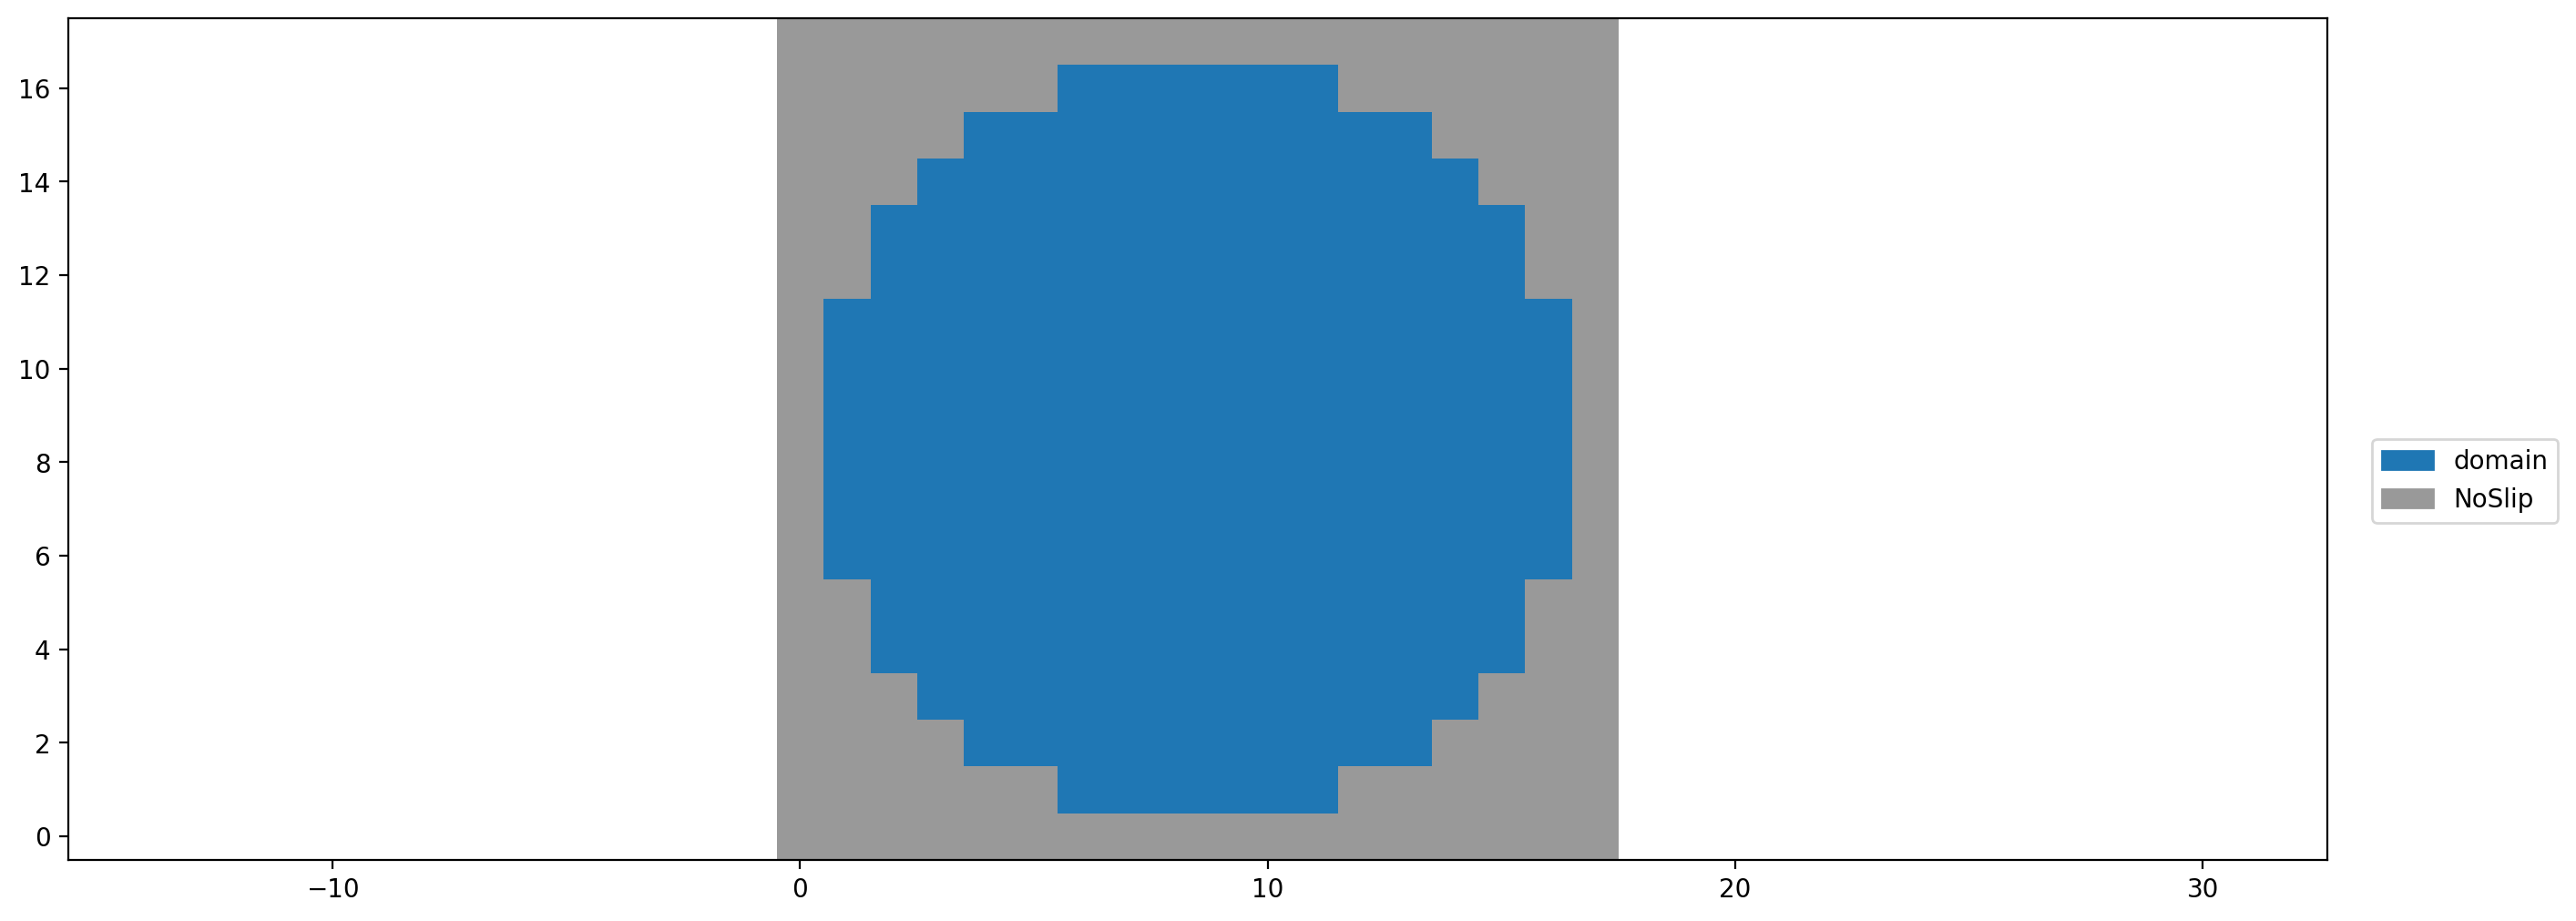

In [5]:
plt.figure(dpi=200)
plt.boundary_handling(sc1.boundary_handling, make_slice[0.5, :, :])

Now the setup is complete. We can run it and look at the velocity profile in the pipe.

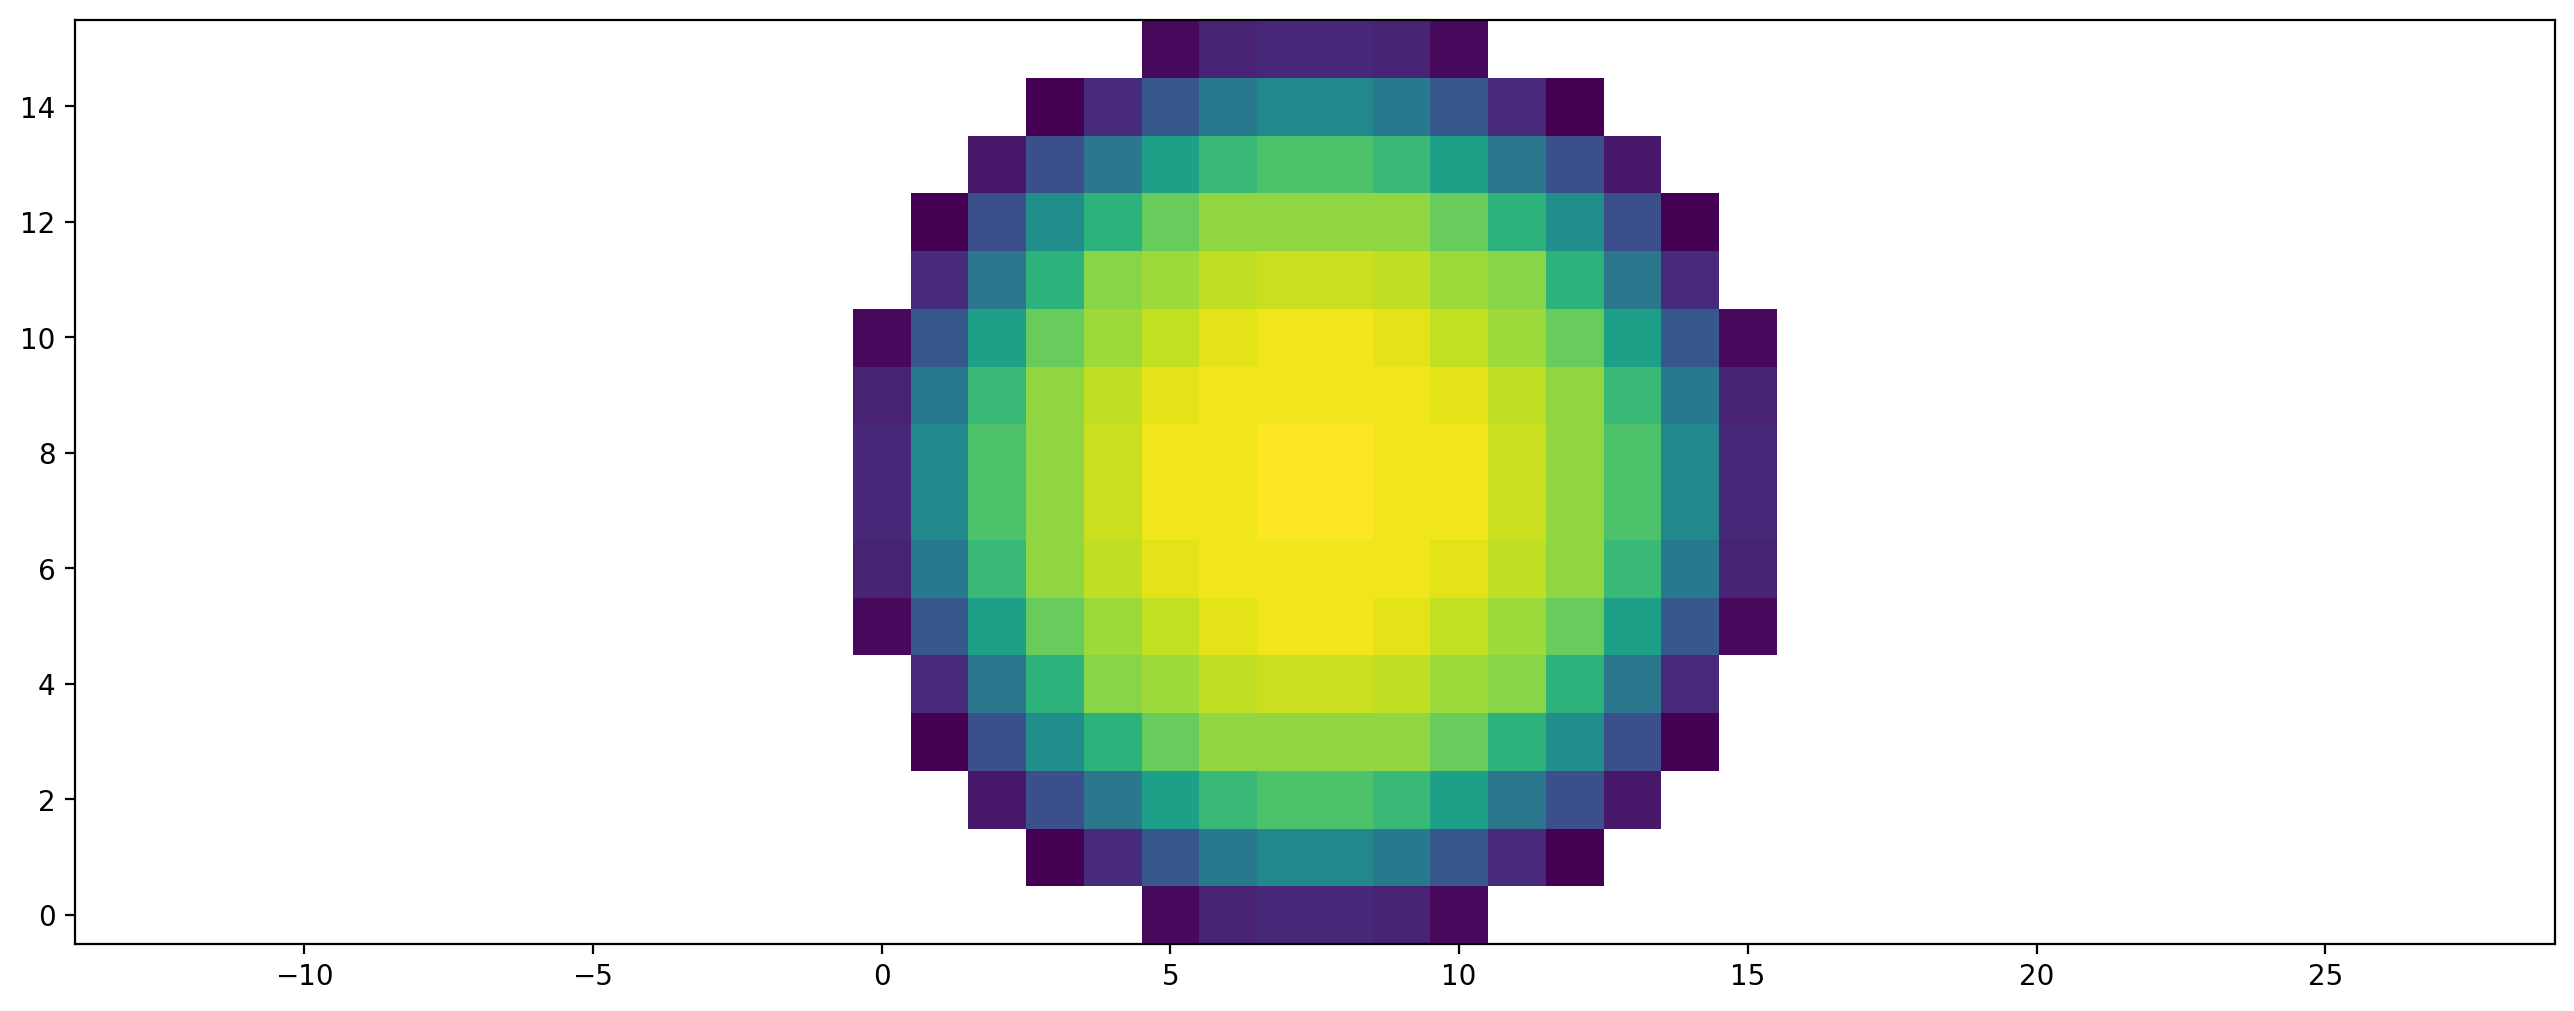

In [6]:
sc1.run(500)
plt.figure(dpi=200)
plt.scalar_field(sc1.velocity[domain_size[0] // 2, :, :, 0]);

## Boundary Setup

Now instead of creating a periodic, force driven channel, we want to drive the flow with a velocity bounce back boundary condition (UBB) at the inlet and a outflow boundary at the outlet. We want the inflow velocity boundary set up to already prescribe the correct, parabolic flow profile. That means we need a different velocity value at each cell. The outflow boundary condition takes the following form:
$$ f_{\overline{1}jkxyzt} = f_{\overline{1}jk(x - \Delta x)yz(t - \Delta t)} \left(c \theta^{\frac{1}{2}} -u \right) \frac{\Delta t}{\Delta x} + \left(1 - \left(c \theta^{\frac{1}{2}} -u \right) \frac{\Delta t}{\Delta x} \right) f_{\overline{1}jk(x - \Delta x)yzt}$$
More information on the outflow condition can be found in appendix F in https://doi.org/10.1016/j.camwa.2015.05.001

Again, we set up a scenario, but this time without external force and without periodicity.

In [7]:
lbm_config = LBMConfig(stencil=Stencil.D3Q27, method=Method.SRT, relaxation_rate=1.9)
config = CreateKernelConfig(target=Target.CPU)
# config = CreateKernelConfig(target=Target.GPU, gpu_indexing_params={'block_size': (128, 1, 1)})

sc2 = LatticeBoltzmannStep(domain_size=domain_size,
                           lbm_config=lbm_config,
                           config=config)


Now another callback function is required to specify the velocities. This callback gets a boundaryData object, that can be used to get an array of `linkPositions`, `fluidCellPositions` and `boundaryCellPositions` of all boundary links. The object also behaves like a dict where the boundary data can be queried and set by name.
Which data one can set, and how its called depends on the concrete boundary condition. The UBB has `vel_0` until `vel_2` data for the x,y and z components of the velocity.

This example also demonstrates how to change boundary parameters during simulation. Here we introduced an activate flag: when True a parabolic inflow is set, when False no inflow velocity is prescribed. 
We'll see later how this is used to turn the inflow on and off. With this technique also time dependent boundary information can be set. Reconfiguring the boundary is costly when running GPU simulations, since the data has to be transferred from CPU to GPU.

In [8]:
def velocity_info_callback(boundary_data, activate=True, **_):
    boundary_data['vel_1'] = 0
    boundary_data['vel_2'] = 0
    
    if activate:
        u_max = 0.1
        y, z = boundary_data.link_positions(1), boundary_data.link_positions(2)
        radius = domain_size[1] // 2
        centered_y = y - radius
        centered_z = z - radius
        dist_to_center = np.sqrt(centered_y**2 + centered_z**2)
        boundary_data['vel_0'] = u_max * (1 - dist_to_center / radius)
    else:
        boundary_data['vel_0'] = 0
    
    
inflow = UBB(velocity_info_callback, dim=sc2.method.dim)

stencil = LBStencil(Stencil.D3Q27)
outflow = ExtrapolationOutflow(stencil[4], sc2.method)

sc2.boundary_handling.set_boundary(inflow, make_slice[0, :, :])
sc2.boundary_handling.set_boundary(outflow, make_slice[-1, :, :])

4

Lastly we can use the callback function from above to set the pipe geometry. This is intentionally done at the end of the setup to overwrite the in- and outflow boundaries in the outermost slices.

In [9]:
sc2.boundary_handling.set_boundary(wall, mask_callback=pipe_geometry_callback)

8

To see the full setup, a few slices through the domain are plotted

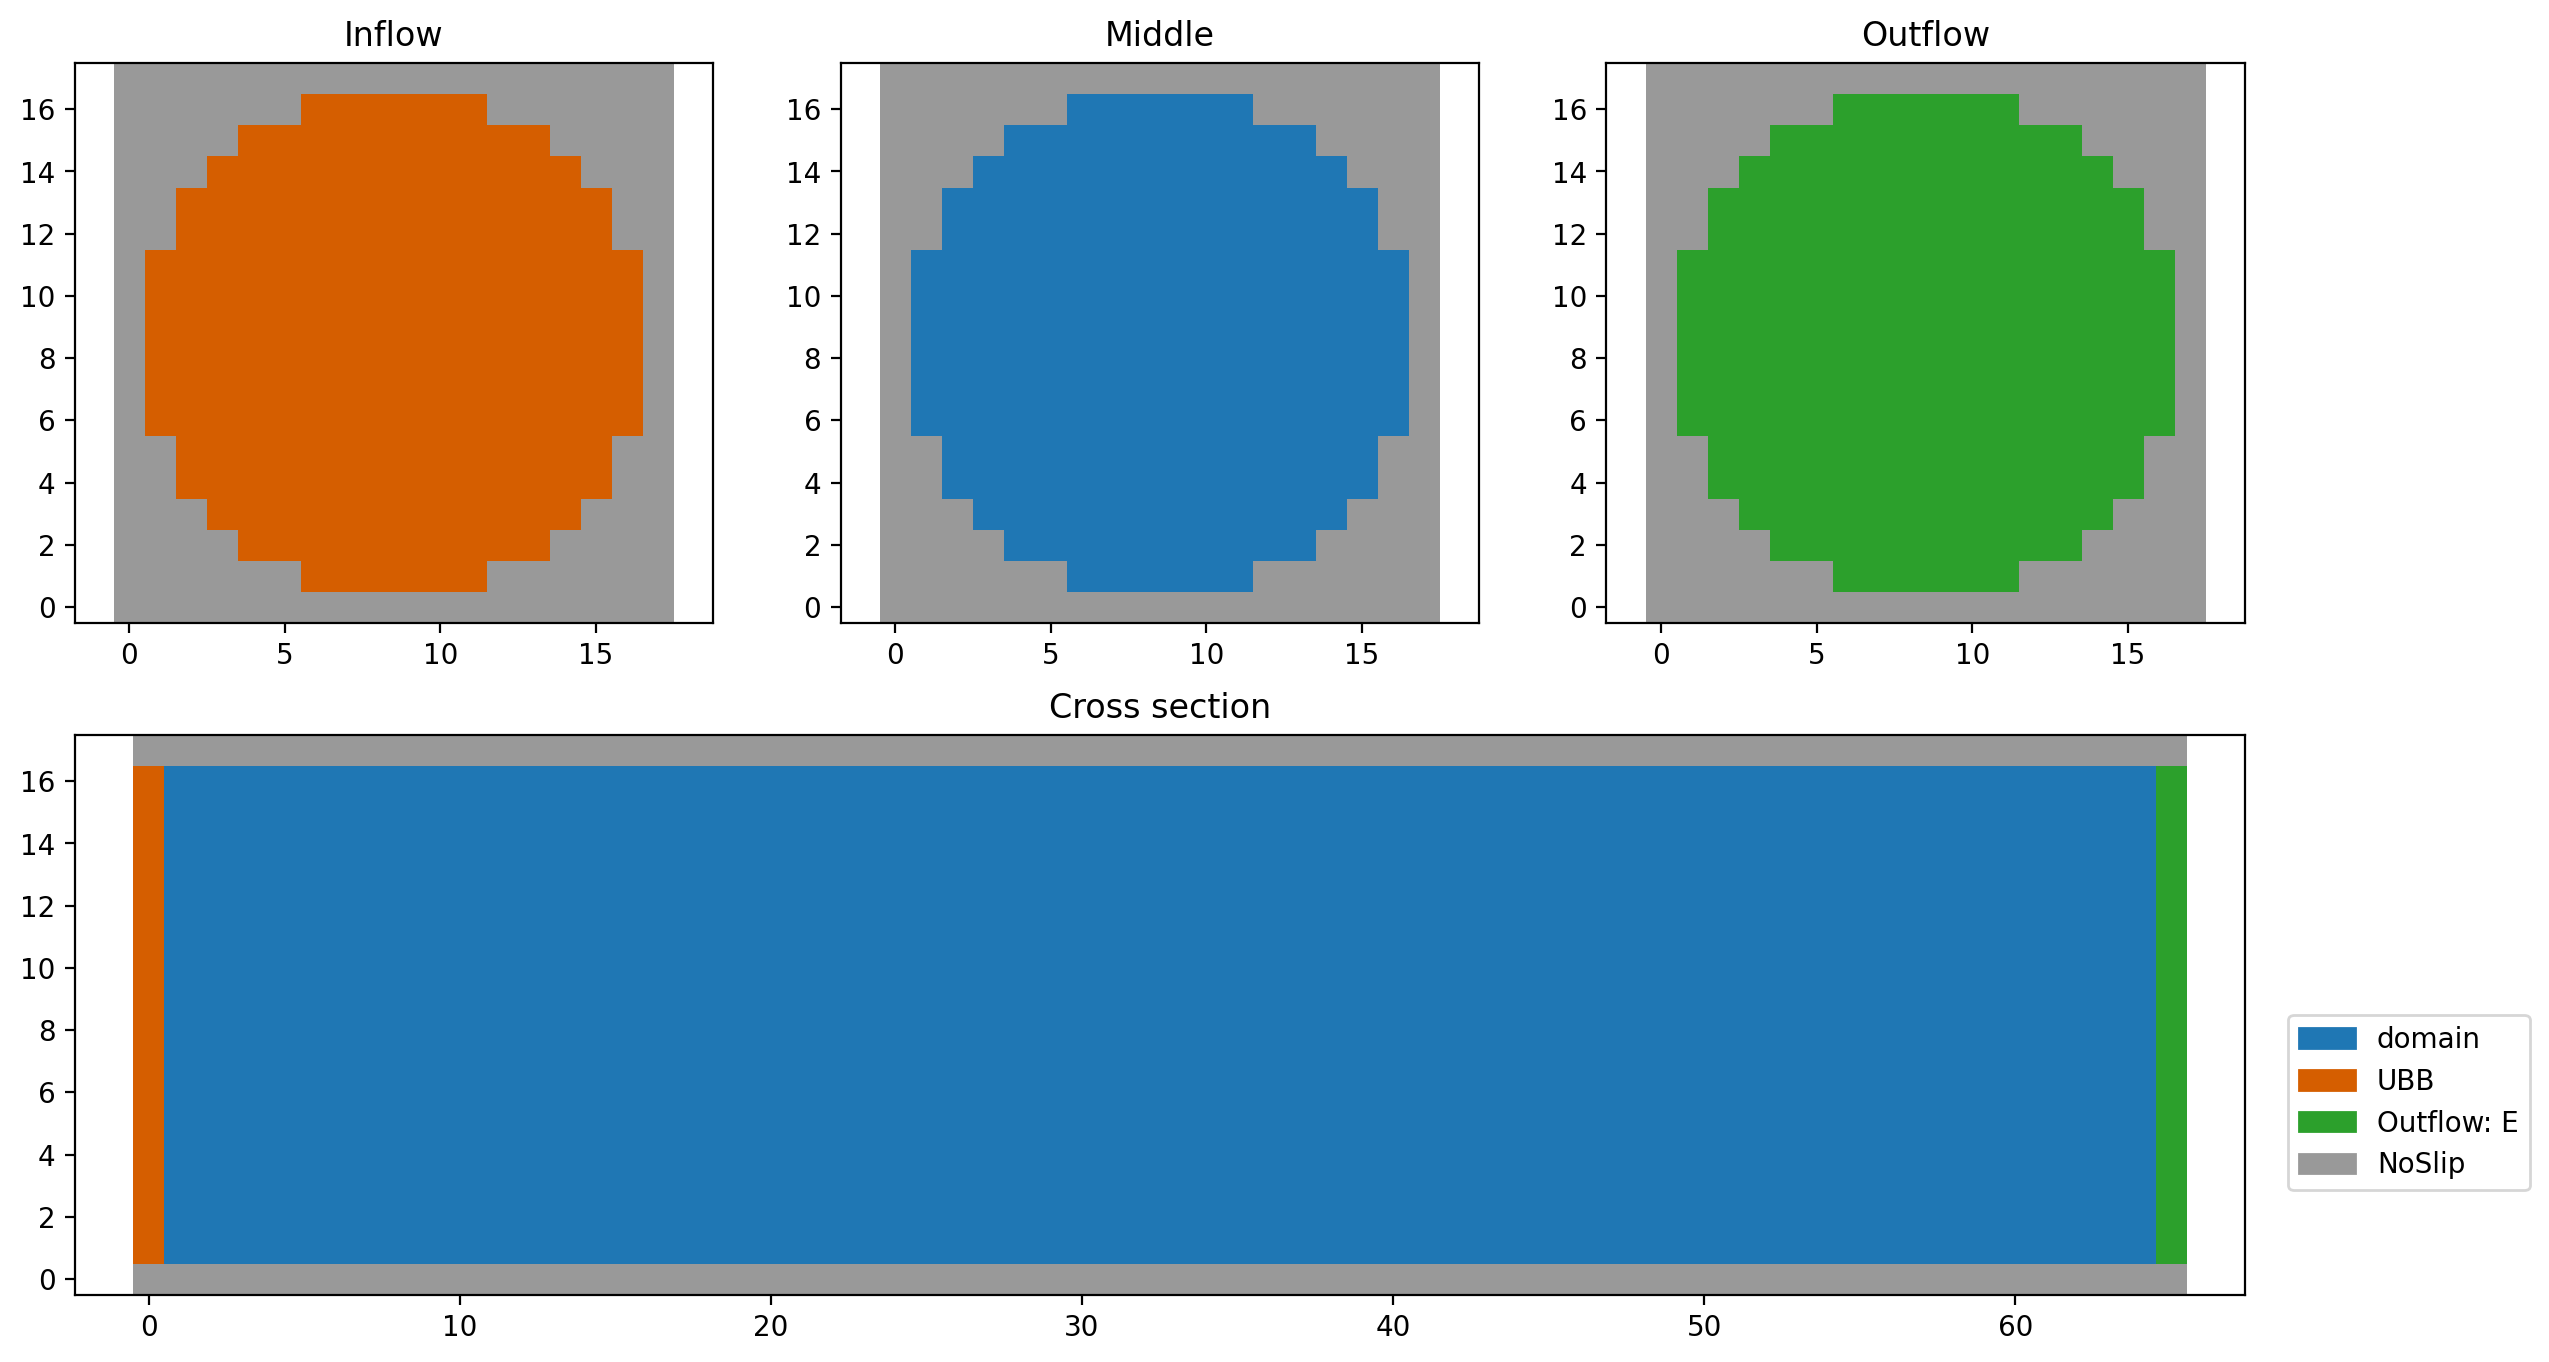

In [10]:
plt.rc('figure', figsize=(14, 8), dpi=200)

plt.subplot(231)
plt.boundary_handling(sc2.boundary_handling, make_slice[0, :, :], show_legend=False)
plt.title('Inflow')

plt.subplot(232)
plt.boundary_handling(sc2.boundary_handling, make_slice[0.5, :, :], show_legend=False)
plt.title('Middle')

plt.subplot(233)
plt.boundary_handling(sc2.boundary_handling, make_slice[-1, :, :], show_legend=False)
plt.title('Outflow')

plt.subplot(212)
plt.boundary_handling(sc2.boundary_handling, make_slice[:, 0.5, :], show_legend=True)
plt.title('Cross section');

We run the channel for a few steps...

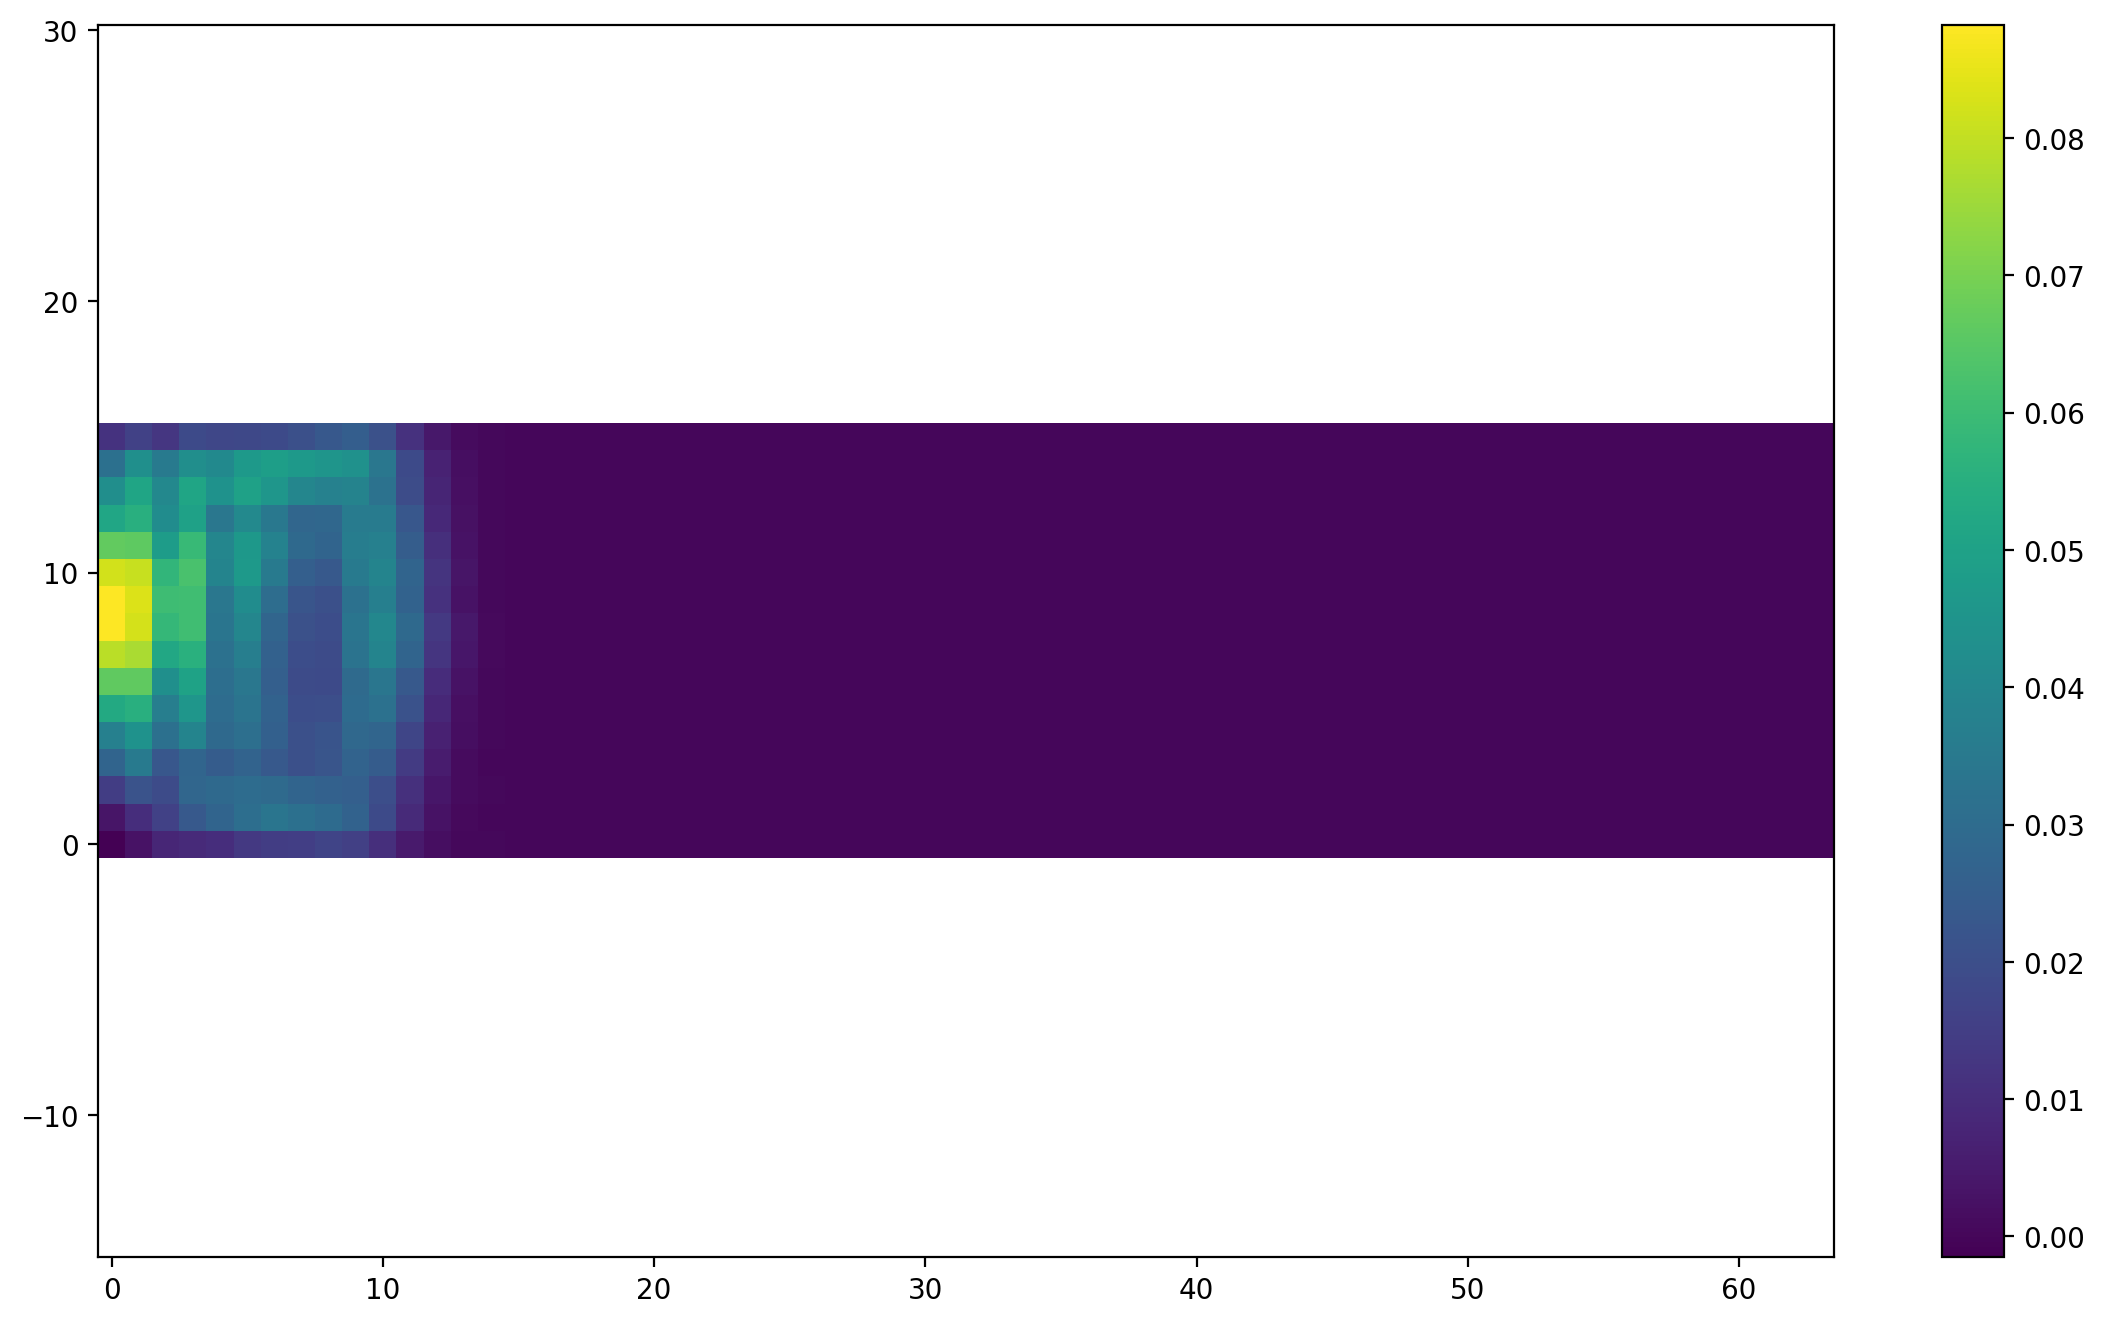

In [11]:
sc2.run(20)
plt.figure(dpi=200)
plt.scalar_field(sc2.velocity[:, 0.5, :, 0])
plt.colorbar();

And then switch off the inflow...

In [12]:
sc2.boundary_handling.trigger_reinitialization_of_boundary_data(activate=False)

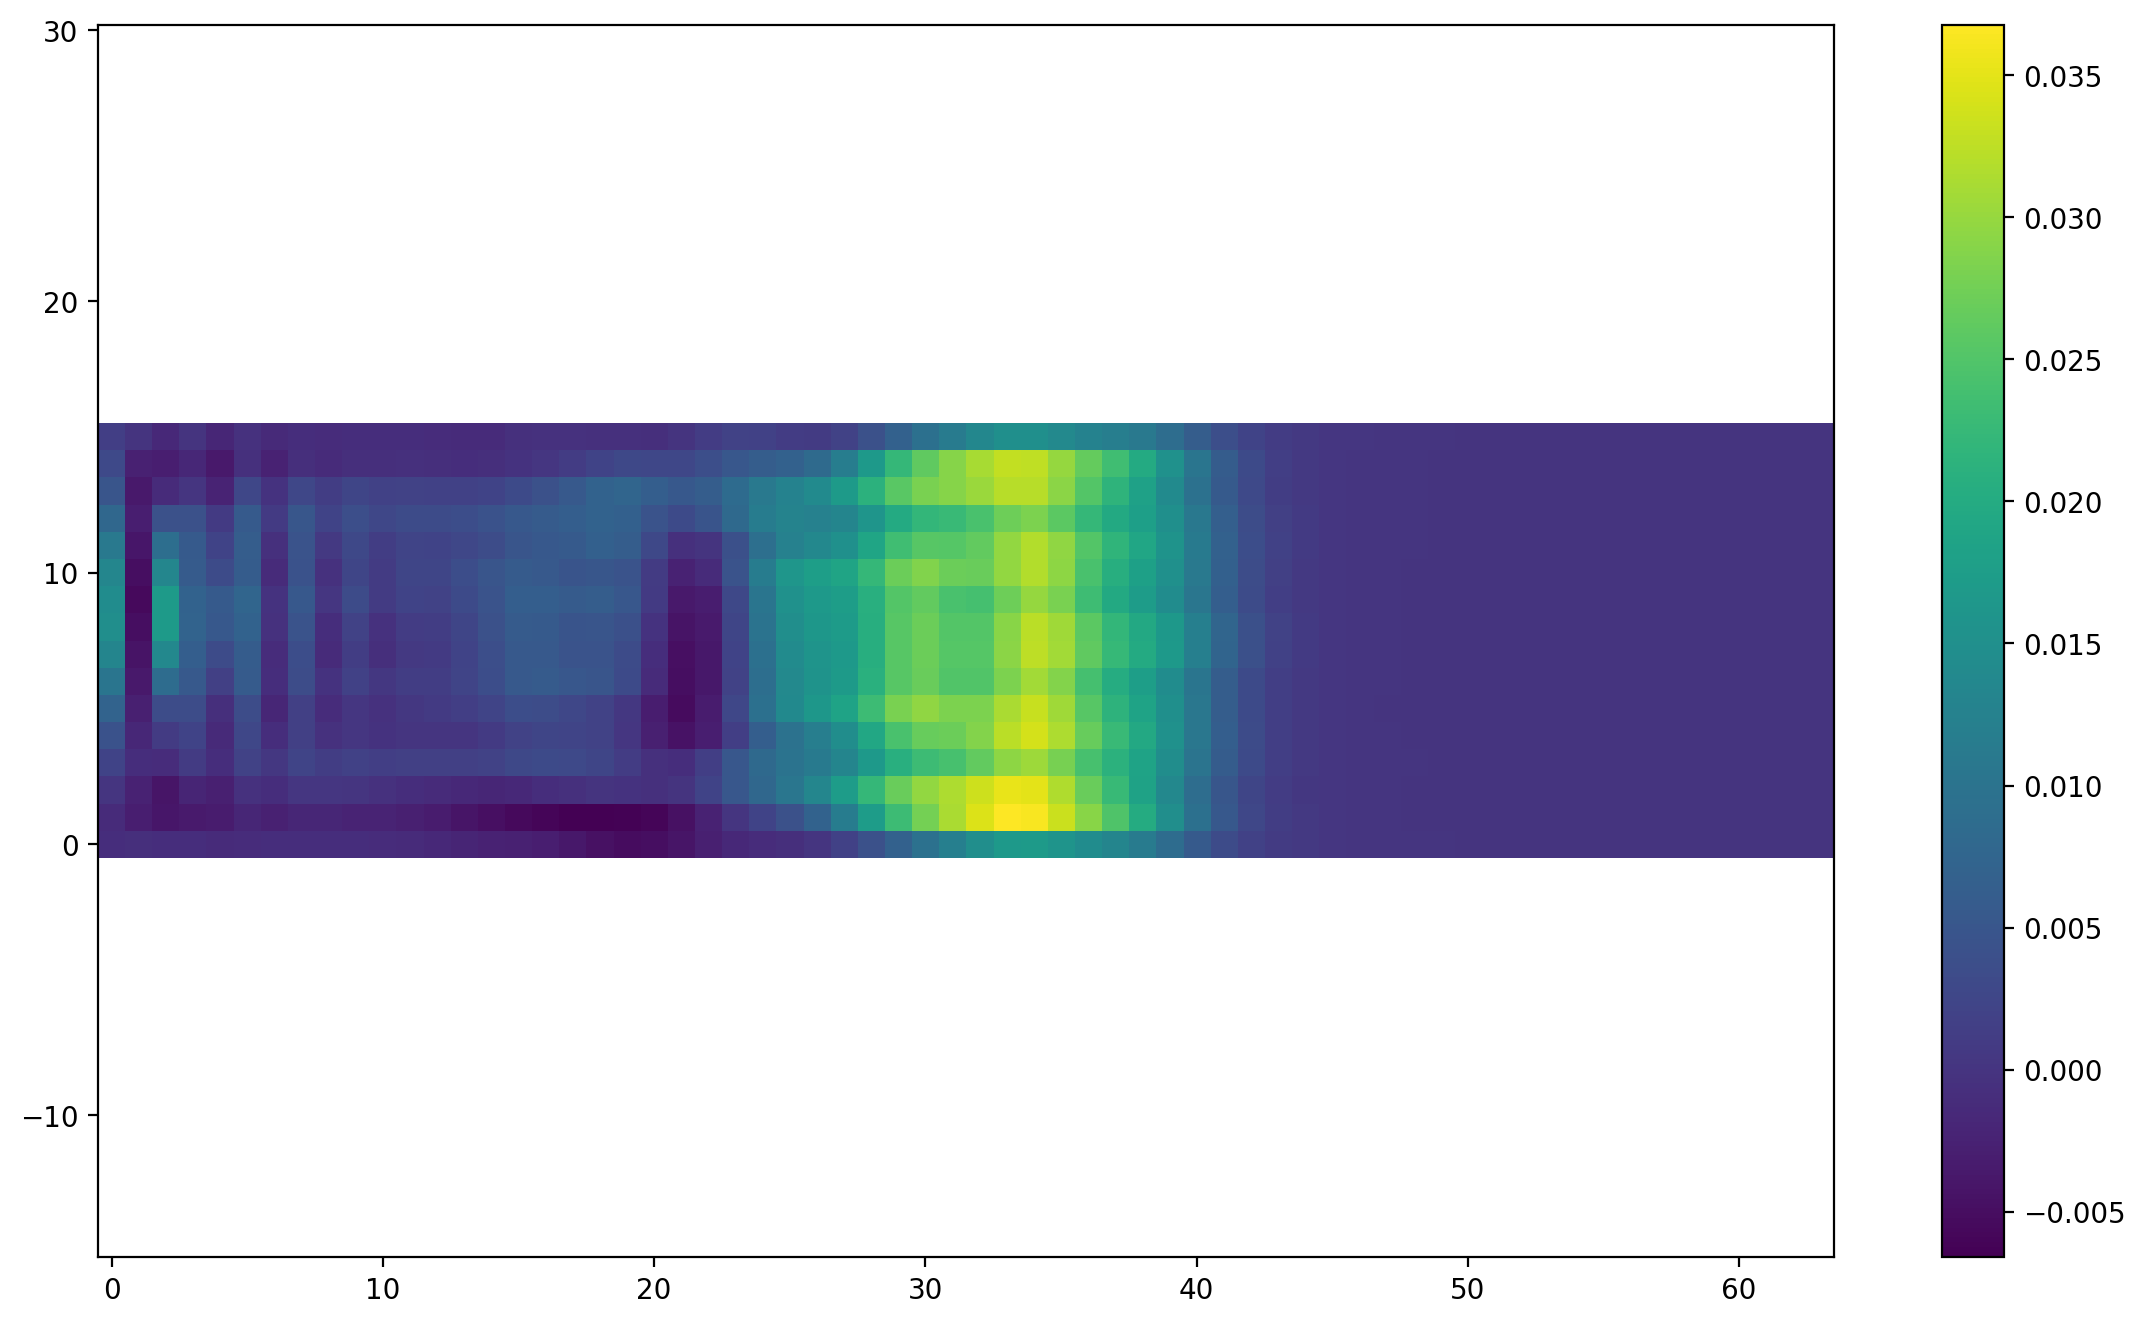

In [13]:
sc2.run(50)
plt.figure(dpi=200)
plt.scalar_field(sc2.velocity[:, 0.5, :, 0])
plt.colorbar();